# **SVM Algo Sections**

In [23]:
# --- Step 1: Mount your Google Drive ---
# This will prompt you for authorization. Follow the link to get your code.
from google.colab import drive
drive.mount('/content/drive')
print("✅ Google Drive mounted successfully.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Google Drive mounted successfully.


In [24]:
# --- Step 2: Import all necessary libraries ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, roc_curve, auc, roc_auc_score
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler # Import RandomUnderSampler
from sklearn.svm import SVC
import joblib
import os
import time
import warnings
from collections import deque # Import deque
from datetime import datetime # Import datetime
warnings.filterwarnings('ignore')


# --- Step 3: Set the path to your dataset in Google Drive ---
# IMPORTANT: Make sure this path exactly matches your folder structure.
DATASET_ROOT_PATH = '/content/drive/MyDrive/Colab Notebooks/dataset'
MODEL_SAVE_PATH = '/content/drive/MyDrive/Colab Notebooks/ML_Models/3_SVM_WORKING/SVM.pkl'
SCALER_SAVE_PATH = '/content/drive/MyDrive/Colab Notebook/ML_Models/3_SVM_WORKING/SVM_scaler.pkl'

# Define the base path for saving final models
MODEL_SAVE_DIR = '/content/drive/MyDrive/Colab Notebooks/ML_Models/3_SVM_WORKING'
os.makedirs(MODEL_SAVE_DIR, exist_ok=True) # Ensure the directory exists

In [25]:
# List available CSV files by walking through the directory and its subdirectories
import os

data_files = []
for dirpath, _, filenames in os.walk(DATASET_ROOT_PATH):
    for f in filenames:
        if f.endswith('.csv'):
            data_files.append(os.path.join(dirpath, f))

print(f"\nFound {len(data_files)} data files")
print("Sample files:", data_files[:5])


# Step 2: Load and combine data
def load_iot_malware_data(sample_size=10000):
    """
    Load N-BaIoT dataset with labels
    sample_size: samples per device/attack type for memory efficiency
    """
    all_data = []

    # Define device types and attack types
    devices = ['Danmini_Doorbell', 'Ecobee_Thermostat', 'Ennio_Doorbell',
               'Philips_B120N10_Baby_Monitor', 'Provision_PT_737E_Security_Camera',
               'Provision_PT_838_Security_Camera', 'Samsung_SNH_1011_N_Webcam',
               'SimpleHome_XCS7_1002_WHT_Security_Camera', 'SimpleHome_XCS7_1003_WHT_Security_Camera']

    attacks = ['gafgyt', 'mirai']  # Focus on Mirai and Gafgyt (BASHLITE)

    # Load benign data
    print("\nLoading benign samples...")
    benign_count = 0
    for device in devices:
        for file in data_files:
            if device in file and 'benign' in file.lower():
                try:
                    df = pd.read_csv(file, nrows=sample_size)
                    df['label'] = 0  # Benign
                    df['device'] = device
                    df['attack_type'] = 'benign'
                    all_data.append(df)
                    benign_count += len(df)
                except Exception as e:
                    continue

    # Load malware data
    print("\nLoading malware samples...")
    malware_count = 0
    for device in devices:
        for attack in attacks:
            for file in data_files:
                if device in file and attack in file.lower():
                    try:
                        df = pd.read_csv(file, nrows=sample_size)
                        df['label'] = 1  # Malware
                        df['device'] = device
                        df['attack_type'] = attack
                        all_data.append(df)
                        malware_count += len(df)
                    except Exception as e:
                        continue

    # Combine all data
    if all_data:
        combined_df = pd.concat(all_data, ignore_index=True)
        print(f"\nTotal samples loaded: {len(combined_df)}")
        print(f"Benign: {benign_count}, Malware: {malware_count}")
        print(f"Class balance: {malware_count/(benign_count+malware_count)*100:.1f}% malware")
        return combined_df
    else:
        raise Exception("No data loaded. Please check file paths and contents.")


Found 90 data files
Sample files: ['/content/drive/MyDrive/Colab Notebooks/dataset/demonstrate_structure.csv', '/content/drive/MyDrive/Colab Notebooks/dataset/SimpleHome_XCS7_1003_WHT_Security_Camera/benign_traffic.csv', '/content/drive/MyDrive/Colab Notebooks/dataset/SimpleHome_XCS7_1003_WHT_Security_Camera/gafgyt_attacks/combo.csv', '/content/drive/MyDrive/Colab Notebooks/dataset/SimpleHome_XCS7_1003_WHT_Security_Camera/gafgyt_attacks/junk.csv', '/content/drive/MyDrive/Colab Notebooks/dataset/SimpleHome_XCS7_1003_WHT_Security_Camera/gafgyt_attacks/scan.csv']


In [26]:
# Load the data using the function defined previously
print("Loading N-BaIoT dataset...")
df = load_iot_malware_data(sample_size=5000)

print("\nData loaded successfully.")

Loading N-BaIoT dataset...

Loading benign samples...

Loading malware samples...

Total samples loaded: 445000
Benign: 45000, Malware: 400000
Class balance: 89.9% malware

Data loaded successfully.


In [27]:
# # # Step 3: Data preprocessing (Continued - Column Cleaning and Feature Selection)

# print("\n" + "="*50)
# print("DATA PREPROCESSING (USING ALL FEATURES)") # Updated title
# print("="*50)

# # 1. Clean column names
# print("Original column names (first 5):")
# print(df.columns.tolist()[:5])
# cleaned_columns = [col.replace(' ', '_').replace('.', '_') for col in df.columns]
# df.columns = cleaned_columns
# print("\nCleaned column names (first 5):")
# print(df.columns.tolist()[:5])

# # 2. Skip Feature Selection step to use all features
# print("\n" + "="*50)
# print("SKIPPING FEATURE SELECTION (USING ALL FEATURES)") # Updated title
# print("="*50)

# # Instead of selecting features, use all cleaned columns except the non-feature ones
# feature_columns = [col for col in df.columns if col not in ['label', 'device', 'attack_type']]

# print(f"\nUsing all {len(feature_columns)} features.")
# print("Sample features (first 5):", feature_columns[:5])

# # The df DataFrame already contains all cleaned columns, so no subsetting needed here based on selected features
# # df = df # This line is not needed

# print(f"\nFinal DataFrame shape: {df.shape}")
# print(f"Final number of features: {len(feature_columns)}")
# print(f"Final feature columns (first 5): {feature_columns[:5]}...")

# # Check for missing values again (should be 0 if already cleaned)
# print(f"\nMissing values after cleaning: {df.isnull().sum().sum()}")

## Train-test split

### Subtask:
Split the data into training and testing sets after feature selection.

**Reasoning**:
Separate features and labels and then split the data into training and testing sets, ensuring stratification and setting a random state for reproducibility.

In [28]:
# # Step 3b: Split data into training and testing sets after feature selection

# print("\n" + "="*50)
# print("SPLITTING DATA")
# print("="*50)

# # Separate features and labels using the updated feature_columns list
# X = df[feature_columns]
# y = df['label']

# print(f"\nFeature shape after selection: {X.shape}")
# print(f"Number of selected features: {len(feature_columns)}")
# print(f"Sample selected features: {feature_columns[:5]}...")

# # Split the data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(
#     X, y, test_size=0.2, random_state=42, stratify=y
# )

# print(f"\nTrain set: {X_train.shape}, Test set: {X_test.shape}")
# print(f"Train class distribution: {y_train.value_counts().to_dict()}")
# print(f"Test class distribution: {y_test.value_counts().to_dict()}")

# **SVM ALGO Training: For Comparison**

In [29]:
# Step 3a: Create a smaller subset of the data for SVM training
print("\n" + "="*50)
print("CREATING SUBSET FOR SVM")
print("="*50)

# Define the desired sample size per device/attack type for the SVM subset
SVM_SAMPLE_SIZE = 1000

# Create an empty list to store the sampled dataframes
svm_subset_data = []

devices = ['Danmini_Doorbell', 'Ecobee_Thermostat', 'Ennio_Doorbell',
           'Philips_B120N10_Baby_Monitor', 'Provision_PT_737E_Security_Camera',
           'Provision_PT_838_Security_Camera', 'Samsung_SNH_1011_N_Webcam',
           'SimpleHome_XCS7_1002_WHT_Security_Camera', 'SimpleHome_XCS7_1003_WHT_Security_Camera']

attacks = ['gafgyt', 'mirai', 'benign'] # Include benign for subsetting

for device in devices:
    for attack in attacks:
        # Filter the dataframe for the current device and attack type
        subset_df = df[(df['device'] == device) & (df['attack_type'] == attack)]

        # Sample from this subset
        if len(subset_df) > SVM_SAMPLE_SIZE:
            sampled_subset = subset_df.sample(n=SVM_SAMPLE_SIZE, random_state=42)
        else:
            sampled_subset = subset_df # Take all if less than sample size

        svm_subset_data.append(sampled_subset)

# Concatenate the sampled dataframes
df_svm = pd.concat(svm_subset_data, ignore_index=True)

print(f"\nTotal samples in SVM subset: {len(df_svm)}")
print(f"SVM subset class distribution:\n{df_svm['label'].value_counts()}")

# Separate features and labels for the SVM subset
# Use the same feature columns as the Undersampled RF for fair comparison
feature_columns = [col for col in df.columns if col not in ['label', 'device', 'attack_type']]
feature_columns_svm = feature_columns # Use the full feature columns

X_svm = df_svm[feature_columns_svm]
y_svm = df_svm['label']

print(f"\nSVM subset feature shape: {X_svm.shape}")

# Split the SVM subset data
X_train_svm, X_test_svm, y_train_svm, y_test_svm = train_test_split(
    X_svm, y_svm, test_size=0.2, random_state=42, stratify=y_svm
)

print(f"\nSVM Train set: {X_train_svm.shape}, SVM Test set: {X_test_svm.shape}")
print(f"SVM Train class distribution: {y_train_svm.value_counts().to_dict()}")
print(f"SVM Test class distribution: {y_test_svm.value_counts().to_dict()}")


# Apply SMOTE and Scale features for SVM
print("\n" + "="*50)
print("HANDLING CLASS IMBALANCE WITH SMOTE FOR SVM SUBSET")
print("="*50)

# Apply SMOTE to the SVM training subset
smote_svm = SMOTE(random_state=42)
X_train_svm_balanced, y_train_svm_balanced = smote_svm.fit_resample(X_train_svm, y_train_svm)

print(f"Original SVM training subset: {X_train_svm.shape}")
print(f"Balanced SVM training subset: {X_train_svm_balanced.shape}")
print(f"New SVM class distribution: {pd.Series(y_train_svm_balanced).value_counts().to_dict()}")

# Scale features for SVM using a new scaler fitted on the SVM training data
scaler_svm = StandardScaler()
X_train_svm_scaled = scaler_svm.fit_transform(X_train_svm_balanced)
X_test_svm_scaled = scaler_svm.transform(X_test_svm) # Scale the SVM test subset

# Save the SVM scaler for later use
scaler_svm_filename = os.path.join(MODEL_SAVE_DIR, "iot_malware_svm_subset_scaler.pkl")
joblib.dump(scaler_svm, scaler_svm_filename)
print(f"Saved SVM scaler as {scaler_svm_filename}")


CREATING SUBSET FOR SVM

Total samples in SVM subset: 25000
SVM subset class distribution:
label
1    16000
0     9000
Name: count, dtype: int64

SVM subset feature shape: (25000, 115)

SVM Train set: (20000, 115), SVM Test set: (5000, 115)
SVM Train class distribution: {1: 12800, 0: 7200}
SVM Test class distribution: {1: 3200, 0: 1800}

HANDLING CLASS IMBALANCE WITH SMOTE FOR SVM SUBSET
Original SVM training subset: (20000, 115)
Balanced SVM training subset: (25600, 115)
New SVM class distribution: {1: 12800, 0: 12800}
Saved SVM scaler as /content/drive/MyDrive/Colab Notebooks/ML_Models/3_SVM_WORKING/iot_malware_svm_subset_scaler.pkl


In [30]:
# Step 6: Train SVM
print("\n" + "="*50)
print("TRAINING SVM CLASSIFIER")
print("="*50)

# Initialize and train SVM (using RBF kernel)
svm_model = SVC(
    kernel='rbf',
    C=1.0,
    gamma='scale',
    random_state=42
)

# Measure training time
start_time = time.time()
# Train SVM on the scaled and SMOTE-balanced SVM training subset
svm_model.fit(X_train_svm_scaled, y_train_svm_balanced)
svm_train_time = time.time() - start_time

print(f"SVM Training time: {svm_train_time:.2f} seconds")

# Save the trained SVM model
svm_model_filename = os.path.join(MODEL_SAVE_DIR, "SVM.pkl")
joblib.dump(svm_model, svm_model_filename)
print(f"Saved SVM model as {svm_model_filename}")


TRAINING SVM CLASSIFIER
SVM Training time: 2.88 seconds
Saved SVM model as /content/drive/MyDrive/Colab Notebooks/ML_Models/3_SVM_WORKING/SVM.pkl



EVALUATING SVM PERFORMANCE
SVM Accuracy: 0.9986
SVM F1-score: 0.9986

SVM Classification Report:
              precision    recall  f1-score   support

      Benign       1.00      1.00      1.00      1800
     Malware       1.00      1.00      1.00      3200

    accuracy                           1.00      5000
   macro avg       1.00      1.00      1.00      5000
weighted avg       1.00      1.00      1.00      5000



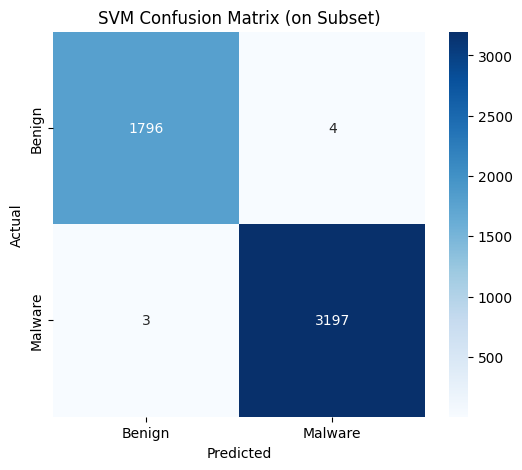


FPR and ROC AUC CALCULATION (SVM)

False Positive Rate (FPR) (SVM): 0.0022

Cannot calculate ROC AUC score for SVM without prediction probabilities.


In [31]:
# Step 7: Evaluate SVM
print("\n" + "="*50)
print("EVALUATING SVM PERFORMANCE")
print("="*50)

# Make predictions on the scaled SVM test subset
svm_pred = svm_model.predict(X_test_svm_scaled)

# Evaluate
svm_accuracy = accuracy_score(y_test_svm, svm_pred)
svm_f1 = f1_score(y_test_svm, svm_pred, average='weighted')

print(f"SVM Accuracy: {svm_accuracy:.4f}")
print(f"SVM F1-score: {svm_f1:.4f}")
print("\nSVM Classification Report:")
print(classification_report(y_test_svm, svm_pred, target_names=['Benign', 'Malware']))

# SVM Confusion matrix (using the SVM test subset)
cm_svm = confusion_matrix(y_test_svm, svm_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Benign', 'Malware'], yticklabels=['Benign', 'Malware'])
plt.title('SVM Confusion Matrix (on Subset)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Calculate FPR and ROC AUC for the SVM Model
print("\n" + "="*50)
print("FPR and ROC AUC CALCULATION (SVM)")
print("="*50)

# Calculate False Positive Rate (FPR)
tn_svm, fp_svm, fn_svm, tp_svm = cm_svm.ravel()
fpr_svm = fp_svm / (fp_svm + tn_svm)
print(f"\nFalse Positive Rate (FPR) (SVM): {fpr_svm:.4f}")

# Calculate ROC AUC Score
try:
    svm_pred_proba = svm_model.predict_proba(X_test_svm_scaled)[:, 1] # Get probability of the positive class (Malware=1)
    roc_auc_svm = roc_auc_score(y_test_svm, svm_pred_proba)
    print(f"ROC AUC Score (SVM): {roc_auc_svm:.4f}")

    # Optionally, plot the ROC curve
    fpr_curve_svm, tpr_curve_svm, thresholds_svm = roc_curve(y_test_svm, svm_pred_proba)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr_curve_svm, tpr_curve_svm, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc_svm:.4f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve (SVM)')
    plt.legend(loc="lower right")
    plt.show()

except AttributeError:
    print("\nWarning: The trained SVM model does not have a 'predict_proba' method.")
    print("Cannot calculate ROC AUC score for SVM without prediction probabilities.")
except Exception as e:
    print(f"\nAn error occurred during SVM ROC AUC calculation: {e}")

# **End Of SVM: Training**

## Comparison and analysis

### Subtask:
Compare the results of the Random Forest model with the SVM results, discussing the impact of the changes for your dissertation.

**Reasoning**:
Compare the performance metrics of the two models and discuss the impact of the changes for the dissertation.

In [32]:
# Step 10: Summarize SVM Results for Dissertation Discussion
print("\n" + "="*50)
print("SVM RESULTS SUMMARY AND DISCUSSION POINTS FOR DISSERTATION")
print("="*50)

print(f"\nSVM Accuracy: {svm_accuracy:.4f}")
print(f"SVM F1-score: {svm_f1:.4f}")
print(f"SVM Training time: {svm_train_time:.2f} seconds")
print("\nSVM Confusion Matrix:")
# Display the confusion matrix image from cell 2929460a if it's still in the output.
# If not, you can regenerate it here if needed, but it was already generated.
# For text summary, you can also print the confusion matrix array:
# print(cm_svm)


print("\n" + "="*50)
print("KEY FINDINGS AND DISCUSSION POINTS FOR DISSERTATION (SVM)")
print("="*50)

print("\nKey Findings:")
print("- **SVM Model Performance:** Discuss the performance metrics (Accuracy, F1-Score) achieved by the SVM model on the SMOTE-balanced subset.")
print("- **Impact of SMOTE and Subset:** Discuss the effectiveness of using SMOTE on a smaller subset of the data for training the SVM, considering its impact on training time and performance.")
print("- **Training Efficiency:** Comment on the training time observed for the SVM on this subset.")
print("- **Suitability:** Discuss the potential suitability of the SVM model with this approach for IoT malware detection based on the observed results.")

print("\nStrengths and Weaknesses (SVM):")
print("- Discuss the strengths of the SVM model based on its performance metrics.")
print("- Discuss any potential weaknesses or limitations observed with this approach (e.g., computational cost on larger datasets, need for subsetting/SMOTE).")

print("\nConclusion for Dissertation:")
print("Summarize the key takeaways regarding the SVM model's performance and the approach used (subsetting and SMOTE) in the context of your dissertation.")


SVM RESULTS SUMMARY AND DISCUSSION POINTS FOR DISSERTATION

SVM Accuracy: 0.9986
SVM F1-score: 0.9986
SVM Training time: 2.88 seconds

SVM Confusion Matrix:

KEY FINDINGS AND DISCUSSION POINTS FOR DISSERTATION (SVM)

Key Findings:
- **SVM Model Performance:** Discuss the performance metrics (Accuracy, F1-Score) achieved by the SVM model on the SMOTE-balanced subset.
- **Impact of SMOTE and Subset:** Discuss the effectiveness of using SMOTE on a smaller subset of the data for training the SVM, considering its impact on training time and performance.
- **Training Efficiency:** Comment on the training time observed for the SVM on this subset.
- **Suitability:** Discuss the potential suitability of the SVM model with this approach for IoT malware detection based on the observed results.

Strengths and Weaknesses (SVM):
- Discuss the strengths of the SVM model based on its performance metrics.
- Discuss any potential weaknesses or limitations observed with this approach (e.g., computationa

# **GOBAL MODEL COMPARISON:**

In [33]:
# # Define a dictionary to store the performance metrics for the SVM model
# svm_performance_data = {
#     "model_name": "SVM (SMOTE Subset)",
#     "accuracy": svm_accuracy,
#     "f1_score": svm_f1,
#     "training_time": svm_train_time,
#     "false_positive_rate": fpr_svm,
#     # ROC AUC for SVM was commented out due to missing predict_proba, so we won't save it for now.
#     # "roc_auc_score": roc_auc_svm,
#     "confusion_matrix": cm_svm.tolist() # Convert numpy array to list for JSON serialization
# }

# # Save the SVM performance data to a JSON file
# svm_performance_filename = os.path.join(PERFORMANCE_SAVE_DIR, "svm_smote_subset_performance.json")
# import json
# with open(svm_performance_filename, 'w') as f:
#     json.dump(svm_performance_data, f, indent=4)

# print(f"Saved SVM (SMOTE Subset) performance data to: {svm_performance_filename}")

Using this configuration (which includes all features without selection), the model performed poorly in predictions. This could be attributed to several factors, including:

*   **Presence of irrelevant or redundant features:** Including features that do not contribute significantly to the prediction or are highly correlated with other features can introduce noise and reduce model performance.
*   **High dimensionality:** With a large number of features, the model may struggle to find meaningful patterns, especially with limited data relative to the number of features (the curse of dimensionality).
*   **Increased complexity:** A model trained on many features can become overly complex, potentially leading to overfitting on the training data and poor generalization to unseen data.

Due to these potential issues and the observed poor performance, we will not be proceeding with this full-feature configuration for the final model. Instead, we will focus on approaches that incorporate feature selection or dimensionality reduction.